In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
import itertools
from collections import Counter
from tensorflow.keras import regularizers
import tensorflow as tf
from nltk.probability import FreqDist
from nltk.util import ngrams
from gensim.models import word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
df = pd.read_csv('data_text/cleaned_reviews.csv', encoding="ISO-8859-1")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,love the led lights connects quickly the recha...,16,1.0
1,neutral,the keyboard itself as keyboard works fine how...,177,4.0
2,positive,the scrolling wheel is not working properly af...,28,5.0
3,neutral,long battery life due to sleep mode was impres...,19,5.0
4,neutral,my bf loves his new headphone the cord is kind...,16,5.0


Consists of class ids 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech

In [63]:
df.count()

sentiments               17340
cleaned_review           17337
cleaned_review_length    17340
review_score             17340
dtype: int64

In [64]:
df.isnull().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

In [65]:
df.dropna(inplace=True)

In [66]:
ps = PorterStemmer() 

def preprocessing(sentence, lemma=True, stemming=True, tokenize=True, stopword=True):

    sentence = str(sentence).lower()
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', ' ', sentence)
    sentence = re.sub(' +', ' ', sentence)

    if tokenize:
        words = word_tokenize(sentence)
    else:
        words = sentence.split()

    if stopword:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    if stemming:
        words = [ps.stem(word) for word in words]

    if lemma:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words), words

In [67]:
df['processed_text'] = ""
df['words_list'] = None

In [68]:
for i, row in df.iterrows():
    processed_sentence, words_list = preprocessing(row['cleaned_review'])
    df.at[i, 'processed_text'] = processed_sentence
    df.at[i, 'words_list'] = words_list

In [69]:
df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score,processed_text,words_list
0,positive,love the led lights connects quickly the recha...,16,1.0,love led light connect quickli recharg featur ...,"[love, led, light, connect, quickli, recharg, ..."
1,neutral,the keyboard itself as keyboard works fine how...,177,4.0,keyboard keyboard work fine howev thing need i...,"[keyboard, keyboard, work, fine, howev, thing,..."
2,positive,the scrolling wheel is not working properly af...,28,5.0,scroll wheel work properli month buy new mous ...,"[scroll, wheel, work, properli, month, buy, ne..."
3,neutral,long battery life due to sleep mode was impres...,19,5.0,long batteri life due sleep mode impress scrol...,"[long, batteri, life, due, sleep, mode, impres..."
4,neutral,my bf loves his new headphone the cord is kind...,16,5.0,bf love new headphon cord kind long complain,"[bf, love, new, headphon, cord, kind, long, co..."


In [70]:
def frequent_ngram(corpus, ngram, n=30):    

    documents = [sentence for sentence in corpus]
    
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    n_grams_flat = [item for sublist in n_grams for item in sublist]

    freq_dist = FreqDist(n_grams_flat)
    top_freq = freq_dist.most_common(n)

    top_freq = [(str(ngram), count) for ngram, count in top_freq]

    return pd.DataFrame(top_freq, columns=["ngram", "count"])

In [71]:
# Most common unigrams
unigrams = frequent_ngram(df['words_list'], 1, 10)
unigrams

,ngram,count
0,"('work',)",7481
1,"('mous',)",6586
2,"('use',)",5664
3,"('great',)",4608
4,"('charg',)",4214
5,"('sound',)",3586
6,"('love',)",3334
7,"('good',)",2985
8,"('like',)",2879
9,"('light',)",2842


In [72]:
# Most frequent bigrams
bigrams = frequent_ngram(df['words_list'], 2, 10)
bigrams

,ngram,count
0,"('stop', 'work')",1116
1,"('sound', 'qualiti')",982
2,"('work', 'great')",886
3,"('batteri', 'life')",660
4,"('work', 'well')",508
5,"('mous', 'work')",495
6,"('great', 'sound')",485
7,"('easi', 'use')",356
8,"('use', 'mous')",339
9,"('hold', 'charg')",325


Text(0.5, 1.0, 'Most common unigrams')

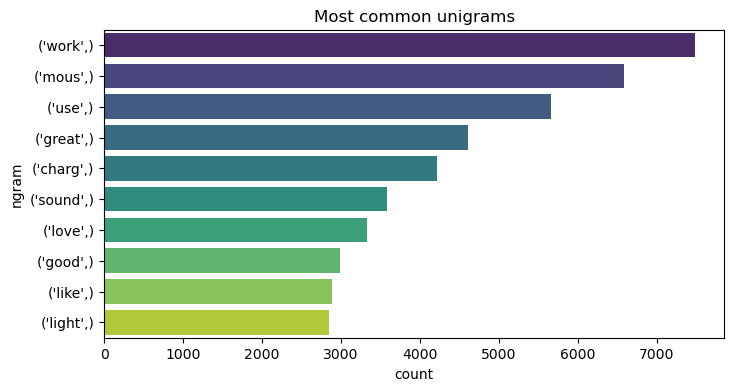

In [73]:
plt.figure(figsize=(8,4))
sns.barplot(x="count", y="ngram", data=unigrams, hue='ngram', palette="viridis")
plt.title("Most common unigrams")

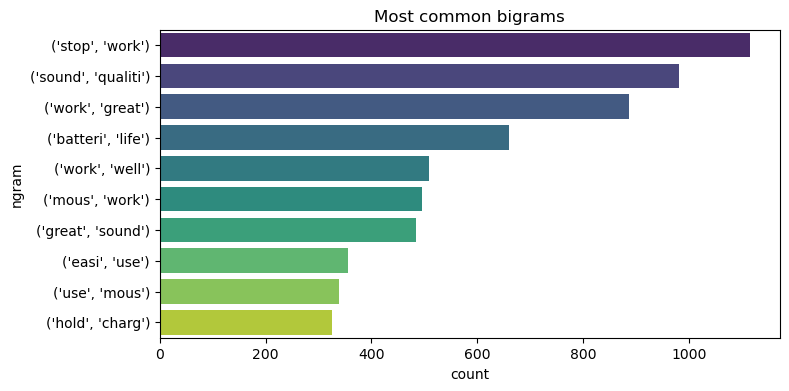

In [74]:
plt.figure(figsize=(8,4))
sns.barplot(x="count", y="ngram", data=bigrams, hue='ngram', palette="viridis")
plt.title("Most common bigrams")
plt.show()

In [75]:
avg_scores = df.groupby('sentiments')[['review_score']].mean().reset_index()
avg_scores

,sentiments,review_score
0,negative,3.362451
1,neutral,3.491905
2,positive,3.799221


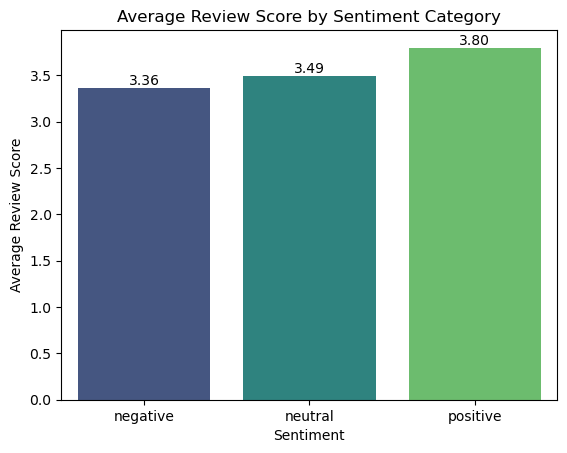

In [76]:
ax = sns.barplot(x='sentiments', y='review_score', data=avg_scores, hue='sentiments', palette='viridis')

plt.title('Average Review Score by Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Average Review Score')

# Adding the text on top of each bar
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
            ha='center', va='bottom')

plt.show()

In [77]:
avg_length = df.groupby('sentiments')[['cleaned_review_length']].mean().reset_index()
avg_length

,sentiments,cleaned_review_length
0,negative,43.981095
1,neutral,22.834127
2,positive,33.051457


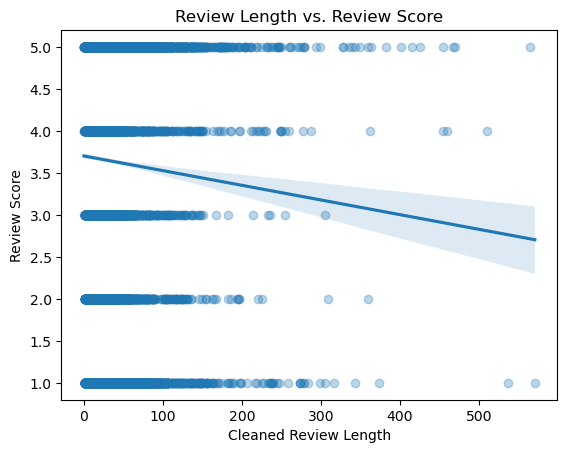

In [78]:
sns.regplot(x='cleaned_review_length', y='review_score', data=df, scatter_kws={'alpha':0.3})

plt.title('Review Length vs. Review Score')
plt.xlabel('Cleaned Review Length')
plt.ylabel('Review Score')
plt.show()

In [79]:
type_counts = df.sentiments.value_counts(dropna=False)
type_counts

sentiments
positive    9503
neutral     6300
negative    1534
Name: count, dtype: int64

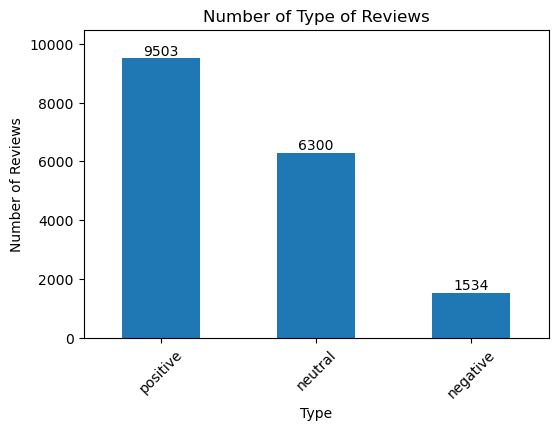

In [80]:
plt.figure(figsize=(6, 4))
bars = type_counts.plot(kind='bar')
plt.title('Number of Type of Reviews')
plt.xlabel('Type')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
current_top = plt.ylim()[1]
padding = current_top * 0.05
plt.ylim(0, current_top + padding)

for index, value in enumerate(type_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

In [81]:
type_counts = df.review_score.value_counts(dropna=False).sort_index()
type_counts

review_score
1.0    3898
2.0    1295
3.0    1117
4.0    1713
5.0    9314
Name: count, dtype: int64

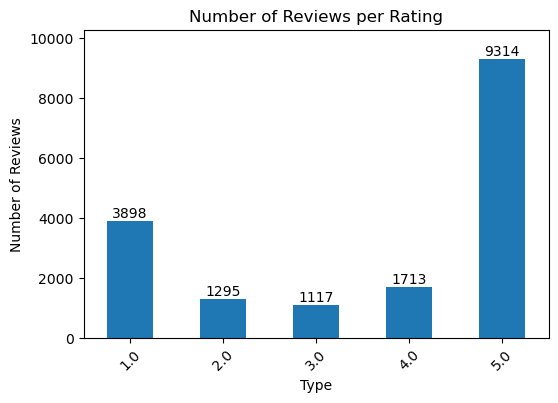

In [82]:
plt.figure(figsize=(6, 4))
bars = type_counts.plot(kind='bar')
plt.title('Number of Reviews per Rating')
plt.xlabel('Type')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
current_top = plt.ylim()[1]
padding = current_top * 0.05
plt.ylim(0, current_top + padding)

for index, value in enumerate(type_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df.sentiments, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

## EDA - Zac

In [84]:
def build_vocab(sentences):
    word_counts = Counter(itertools.chain(*sentences))
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

In [85]:
def get_embeddings(inp_data, vocabulary_inv, size_features=100,
                   mode='skipgram', min_word_count=2, context= 7, negative_samples=0, hs = 1):
    model_name = "embedding"
    model_name = os.path.join(model_name)
    num_workers = 15 
    downsampling = 1e-2  
    print('Training Word2Vec model...')
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    sg = 1 if mode == 'skipgram' else 0
    print(f'Model: {mode}')

    embedding_model = word2vec.Word2Vec(sentences, 
                                        workers=num_workers,
                                        sg=sg, 
                                        vector_size=size_features,
                                        min_count=min_word_count, 
                                        window=context,
                                        seed = 42, 
                                        sample=downsampling, 
                                        hs = hs,
                                        negative=negative_samples)
    
    print("Saving Word2Vec model {}".format(model_name))
    
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)

    return embedding_weights

In [86]:
tagged_train_data = [word_tokenize(review) for review in X_train]
tagged_test_data = [word_tokenize(review) for review in X_test]
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_train_data)
inp_data = [[vocabulary[word] for word in text] for text in tagged_train_data]

In [87]:
embedding_weights_2vec = get_embeddings(inp_data, vocabulary_inv)

Training Word2Vec model...
Model: skipgram
Saving Word2Vec model embedding


In [88]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    length = 1
    for w in doc:
        try:
            vec += embedding_weights_2vec[vocabulary[w]]
            length += 1
        except:
            continue
    vec = vec / length
    train_vec.append(vec)

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 1
    for w in doc:
        try:
            vec += embedding_weights_2vec[vocabulary[w]]
            length += 1
        except:
            continue
    vec = vec / length
    test_vec.append(vec)

In [89]:
lengths = []
for i, elem in enumerate(train_vec):
    try:
        lengths.append(len(elem))
    except TypeError:
        print(f"Element at index {i} is not a sequence.")

if len(set(lengths)) == 1:
    print("All elements have the same length.")
else:
    print("Elements have varying lengths.")

print(f"All lengths: {set(lengths)}")

Element at index 889 is not a sequence.
Element at index 976 is not a sequence.
Element at index 1419 is not a sequence.
Element at index 2692 is not a sequence.
Element at index 2704 is not a sequence.
Element at index 2762 is not a sequence.
Element at index 3444 is not a sequence.
Element at index 3619 is not a sequence.
All elements have the same length.
All lengths: {100}


In [90]:
invalid_indices = [i for i, elem in enumerate(train_vec) if not isinstance(elem, (list, np.ndarray)) or len(elem) != 100]

cleaned_train_vec = [elem for i, elem in enumerate(train_vec) if i not in invalid_indices]
cleaned_y_train = [label for i, label in enumerate(y_train) if i not in invalid_indices]

print(f"Original length: {len(train_vec)}, Cleaned length: {len(cleaned_train_vec)}")
print(f"Original labels length: {len(y_train)}, Cleaned labels length: {len(cleaned_y_train)}")

Original length: 6934, Cleaned length: 6926
Original labels length: 6934, Cleaned labels length: 6926


In [91]:
invalid_indices = [i for i, elem in enumerate(test_vec) if not isinstance(elem, (list, np.ndarray)) or len(elem) != 100]

cleaned_test_vec = [elem for i, elem in enumerate(test_vec) if i not in invalid_indices]
cleaned_y_test = [label for i, label in enumerate(y_test) if i not in invalid_indices]

print(f"Original length: {len(test_vec)}, Cleaned length: {len(cleaned_test_vec)}")
print(f"Original labels length: {len(y_test)}, Cleaned labels length: {len(cleaned_y_test)}")

Original length: 3468, Cleaned length: 3455
Original labels length: 3468, Cleaned labels length: 3455


In [92]:
clf = LogisticRegression(max_iter=10000).fit(cleaned_train_vec, cleaned_y_train)
preds = clf.predict(cleaned_test_vec)

In [93]:
accuracy = accuracy_score(cleaned_y_test, preds)
print(f"Accuracy: {accuracy}")

f1_macro = f1_score(cleaned_y_test, preds, average='macro')
f1_micro = f1_score(cleaned_y_test, preds, average='micro')
print(f"Macro F1 Score: {f1_macro}")
print(f"Micro F1 Score: {f1_micro}")

Accuracy: 0.734876989869754
Macro F1 Score: 0.5397286577899986
Micro F1 Score: 0.734876989869754


## CountVectorizer - Gaetan

In [96]:
vectorizer = CountVectorizer(binary=True)
xtrain_vectors = vectorizer.fit_transform(X_train)
xval_vectors = vectorizer.transform(X_val)
xtest_vectors = vectorizer.transform(X_test)

clf = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300)
clf.fit(xtrain_vectors, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1, random_state=0,
                     scoring='accuracy', verbose=3)

In [97]:
y_prob_1 = clf.predict_proba(xtest_vectors)
y_pred_1 = clf.predict(xtest_vectors)

auroc_ovr = roc_auc_score(y_test, y_prob_1, multi_class='ovr', average='macro')
macro_f1 = f1_score(y_test, y_pred_1, average='macro')
micro_f1 = f1_score(y_test, y_pred_1, average='micro')

print(f"Macro F1-score: {macro_f1}")
print(f"Micro F1-score: {micro_f1}")
print(f"AUROC: {auroc_ovr}")

Macro F1-score: 0.748472722741123
Micro F1-score: 0.8304498269896193
AUROC: 0.9082703674390699


## TF

In [98]:
vectorizer = CountVectorizer()
xtrain_vectors = vectorizer.fit_transform(X_train)
xval_vectors = vectorizer.transform(X_val)
xtest_vectors = vectorizer.transform(X_test)

clf2 = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300)
clf2.fit(xtrain_vectors, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1, random_state=0,
                     scoring='accuracy', verbose=3)

In [99]:
y_prob_1 = clf2.predict_proba(xtest_vectors)
y_pred_1 = clf2.predict(xtest_vectors)

auroc_ovr = roc_auc_score(y_test, y_prob_1, multi_class='ovr', average='macro')
macro_f1 = f1_score(y_test, y_pred_1, average='macro')
micro_f1 = f1_score(y_test, y_pred_1, average='micro')

print(f"Macro F1-score: {macro_f1}")
print(f"Micro F1-score: {micro_f1}")
print(f"AUROC: {auroc_ovr}")

Macro F1-score: 0.7553105446452717
Micro F1-score: 0.8376585928489043
AUROC: 0.9075766524973868


## CountVectorizer with N_Grams

In [101]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vect, y_train)

LogisticRegression(max_iter=1000)

In [102]:

y_val_pred = model.predict(X_val_vect)
val_accuracy = accuracy_score(y_val, y_val_pred)
f1_micro = f1_score(y_val, y_val_pred, average='micro')
f1_macro = f1_score(y_val, y_val_pred, average='macro')

y_val_proba = model.predict_proba(X_val_vect)
auroc = roc_auc_score(y_val, y_val_proba, multi_class='ovr')

In [103]:
predicted_categories_examples = model.predict(X_val_vect[:3])

actual_categories_examples = y_val[:3].values

for actual, predicted in zip(actual_categories_examples, predicted_categories_examples):
    print(f"Actual: {actual} - Predicted: {predicted}")

Actual: neutral - Predicted: neutral
Actual: positive - Predicted: positive
Actual: negative - Predicted: neutral


In [104]:
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score (Micro)', 'F1 Score (Macro)', 'AUROC'],
    'n_grams': [val_accuracy, f1_micro, f1_macro, auroc]
})

results_df

,Metric,n_grams
0,Accuracy,0.847729
1,F1 Score (Micro),0.847729
2,F1 Score (Macro),0.770088
3,AUROC,0.931400


## TF-IDF - Iñaki

In [108]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [109]:
lg = LogisticRegression(max_iter=10000, solver='lbfgs', penalty='l2', C=1, class_weight='balanced')
model = lg.fit(X_train_tfidf, y_train)

y_val_pred = model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
f1_micro = f1_score(y_val, y_val_pred, average='micro')
f1_macro = f1_score(y_val, y_val_pred, average='macro')

y_val_proba = model.predict_proba(X_val_tfidf)
auroc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')

In [110]:
print(f"Validation Accuracy: {val_accuracy}")
print(f"Micro F1 Score: {f1_micro}")
print(f"Macro F1 Score: {f1_macro}")
print(f"AUROC (One-vs-Rest): {auroc}")

Validation Accuracy: 0.7959625090122566
Micro F1 Score: 0.7959625090122566
Macro F1 Score: 0.7314968992397993
AUROC (One-vs-Rest): 0.9215836602373833


## TF-IDF using NN

In [111]:
y_train = y_train.map({'negative': 0, 'positive': 1, 'neutral': 2})
y_val = y_val.map({'negative': 0, 'positive': 1, 'neutral': 2})
y_test = y_test.map({'negative': 0, 'positive': 1, 'neutral': 2})

In [115]:
X_train_dense = X_train_tfidf.toarray()
X_val_dense = X_val_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_dense.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [116]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

In [118]:
history = model.fit(X_train_dense, y_train, epochs=10, validation_data=(X_val_dense, y_val))

Epoch 1/10


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test Accuracy: {test_acc}')